## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pypfopt.plotting as plotting
from pypfopt.expected_returns import mean_historical_return
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import discrete_allocation
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import EfficientFrontier
from pypfopt import objective_functions
from pypfopt import base_optimizer
from pypfopt.discrete_allocation import DiscreteAllocation
from pypfopt.hierarchical_portfolio import HRPOpt

from custom_allocation import CustomDiscreteAllocation

In [2]:
import requests
from bs4 import BeautifulSoup

# URL of the Wikipedia page containing the S&P 500 components
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'

# Send a GET request to the URL and get the page content
response = requests.get(url)
content = response.content

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(content, 'html.parser')

# Find the table containing the stock data
table = soup.find('table', {'class': 'wikitable sortable'})

# Find all rows in the table
rows = table.find_all('tr')

# Iterate over the rows and extract the stock symbols
sp500_stocks = []
for row in rows[1:]:
    cells = row.find_all('td')
    stock_symbol = cells[0].text.strip()
    sp500_stocks.append(stock_symbol)

# Print the list of S&P 500 stocks
for stock in sp500_stocks:
    print(stock)

MMM
AOS
ABT
ABBV
ACN
ATVI
ADM
ADBE
ADP
AAP
AES
AFL
A
APD
AKAM
ALK
ALB
ARE
ALGN
ALLE
LNT
ALL
GOOGL
GOOG
MO
AMZN
AMCR
AMD
AEE
AAL
AEP
AXP
AIG
AMT
AWK
AMP
ABC
AME
AMGN
APH
ADI
ANSS
AON
APA
AAPL
AMAT
APTV
ACGL
ANET
AJG
AIZ
T
ATO
ADSK
AZO
AVB
AVY
AXON
BKR
BALL
BAC
BBWI
BAX
BDX
WRB
BRK.B
BBY
BIO
TECH
BIIB
BLK
BK
BA
BKNG
BWA
BXP
BSX
BMY
AVGO
BR
BRO
BF.B
BG
CHRW
CDNS
CZR
CPT
CPB
COF
CAH
KMX
CCL
CARR
CTLT
CAT
CBOE
CBRE
CDW
CE
CNC
CNP
CDAY
CF
CRL
SCHW
CHTR
CVX
CMG
CB
CHD
CI
CINF
CTAS
CSCO
C
CFG
CLX
CME
CMS
KO
CTSH
CL
CMCSA
CMA
CAG
COP
ED
STZ
CEG
COO
CPRT
GLW
CTVA
CSGP
COST
CTRA
CCI
CSX
CMI
CVS
DHI
DHR
DRI
DVA
DE
DAL
XRAY
DVN
DXCM
FANG
DLR
DFS
DIS
DG
DLTR
D
DPZ
DOV
DOW
DTE
DUK
DD
DXC
EMN
ETN
EBAY
ECL
EIX
EW
EA
ELV
LLY
EMR
ENPH
ETR
EOG
EPAM
EQT
EFX
EQIX
EQR
ESS
EL
ETSY
RE
EVRG
ES
EXC
EXPE
EXPD
EXR
XOM
FFIV
FDS
FICO
FAST
FRT
FDX
FITB
FSLR
FE
FIS
FI
FLT
FMC
F
FTNT
FTV
FOXA
FOX
BEN
FCX
GRMN
IT
GEHC
GEN
GNRC
GD
GE
GIS
GM
GPC
GILD
GL
GPN
GS
HAL
HIG
HAS
HCA
PEAK
HSIC
HSY
HES
HPE
HLT
HOLX
HD
HON
HRL
HST


In [3]:
len(sp500_stocks)

503

In [4]:
import random

# Set the seed for reproducibility
random.seed(42)

# Generate random selection of 20 stocks
random_stocks = random.sample(sp500_stocks, 20)

# Print the randomly selected stocks
for stock in random_stocks:
    print(stock)

MCO
AXON
A
PPG
DHI
COP
C
BK
PNC
ATO
NCLH
TYL
KLAC
AAPL
MMC
GNRC
ALB
ALK
ACGL
CINF


MCO
AXON
A
PPG
DHI
COP
C
BK
PNC
ATO
NCLH
TYL
KLAC
AAPL
MMC
GNRC
ALB
ALK
ACGL
CINF

## Getting the Data

In [5]:
start_date = date(2020,1,1)
end_date = date(2020, 12, 31)

# Define the ticker list
tickers_list = random_stocks

# Fetch the training data
import yfinance as yf


train_data = yf.download(tickers_list, start=start_date, end=end_date)['Adj Close']


# Print the available tickers
#print(train_data.keys())
#print(data.iloc[-1])
# Print first 5 rows of the data
#print(data.head())
#print(data.tail())

[*********************100%***********************]  20 of 20 completed


In [6]:
# Download benchmark data - We can also use Buffet's Portfolio as a Benchmark
spy_data = yf.download('SPY', start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  1 of 1 completed


# Applying Markowitz

In [7]:
# Prepare historical price data for assets
#historical_prices = pd.read_csv('historical_prices.csv', index_col=0, parse_dates=True)
historical_prices = train_data


# Calculate expected returns
returns = expected_returns.mean_historical_return(historical_prices)
#Add shrinkage here
#https://pyportfolioopt.readthedocs.io/en/latest/RiskModels.html#pypfopt.risk_models.CovarianceShrinkage
cov_matrix = risk_models.sample_cov(historical_prices)

# Create an instance of EfficientFrontier
#ef = EfficientFrontier(returns, cov_matrix,weight_bounds = (0,0.2))
ef = EfficientFrontier(returns, cov_matrix, weight_bounds = (0,0.2))

## Efficient Frontier with random portfolios

Maximise the Sharpe Ratio. The result is also referred to as the tangency portfolio, as it is the portfolio for which the capital market line is tangent to the efficient frontier.

This is a convex optimization problem after making a certain variable substitution. See Cornuejols and Tutuncu (2006) for more.

Because max_sharpe() makes a variable substitution, additional objectives may not work as intended.

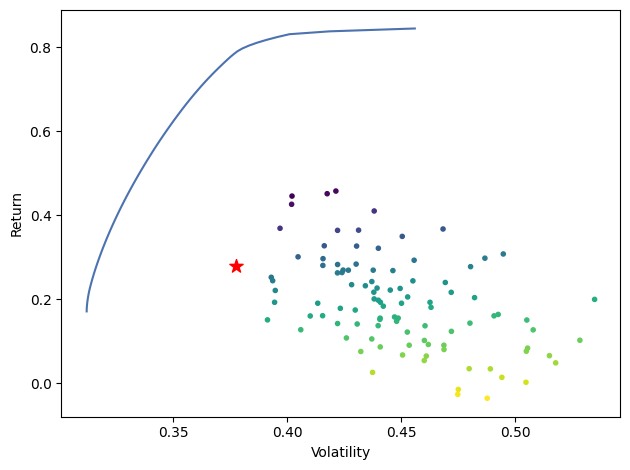

In [8]:
fig, ax = plt.subplots()
ef_optimize = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

### Choosing Optimization Strategy (Comment out the other approach you want to use)

### adding gamma for diversification - https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html#l2-regularisation
ef_optimize.add_objective(objective_functions.L2_reg, gamma=1.5)


### adding transaction costs objective function - https://github.com/robertmartin8/PyPortfolioOpt/blob/master/cookbook/3-Advanced-Mean-Variance-Optimisation.ipynb
# Pretend that you started with a default-weight allocation
#initial_weights = np.array([1/len(tickers_list)] * len(tickers_list))
#ef_optimize.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)

#For Min Volatility
ef_optimize.min_volatility()

#For Max Sharpe - 
#max_sharpe transforms the optimization problem so additional objectives eg. transaction costs, gamma may not work as expected.

#ef_optimize.max_sharpe()

# Markowitz with Target Volatility

#target_volatility = 0.50
#ef_optimize.efficient_risk(target_volatility)

# Find the tangency portfolio

ret_tangent, std_tangent, _ = ef_optimize.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 100
w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
# Normalize weights to sum up to 1 - to make sure they lie within efficient frontier
w = w / np.sum(w, axis=1, keepdims=True)  
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
#ax.set_title("Efficient Frontier with random portfolios")
#ax.legend()
ax.get_legend().remove()
plt.tight_layout()
#Saves the output file as a transparent image
plt.savefig("ef_scatter.png", dpi=200, transparent=True)
plt.show()

In [9]:
# Print Weights - Max Sharpe
cleaned_weights = ef_optimize.clean_weights()
print(cleaned_weights)

OrderedDict([('A', 0.08031), ('AAPL', 0.06763), ('ACGL', 0.03398), ('ALB', 0.04677), ('ALK', 0.02097), ('ATO', 0.08083), ('AXON', 0.05295), ('BK', 0.05893), ('C', 0.01538), ('CINF', 0.04502), ('COP', 0.02604), ('DHI', 0.05109), ('GNRC', 0.05482), ('KLAC', 0.03442), ('MCO', 0.04839), ('MMC', 0.08106), ('NCLH', 0.0), ('PNC', 0.03345), ('PPG', 0.06736), ('TYL', 0.1006)])


# Backtesting - In Sample

In [10]:
#to know the expected performance of the portfolio with optimal weights w
ef_optimize.portfolio_performance(verbose=True)

Expected annual return: 27.9%
Annual volatility: 37.8%
Sharpe Ratio: 0.69


(0.2793275708666972, 0.3777801002687257, 0.6864511145034641)

## Comparison with Benchmark Chart

### In sample graph comparison with Benchmark

In [11]:
# Create an empty Series to store portfolio returns
portfolio_returns_1 = pd.Series()
portfolio_returns_1.index.name = 'Date'

# Extract unique years
unique_years = historical_prices.index.year.unique()

In [12]:
# Iterate through each year
for year in unique_years:
    
    # Filter the DataFrame for the current year
    current_year_prices = historical_prices[historical_prices.index.year == year]
    # to get the last day of the previous year prices
    previous_year_prices = historical_prices[historical_prices.index.year == year-1]
    # Concatenate the last day of the previous year with the current year's data
    # (to avoid NaN value for the first day of the year)
    current_year_prices = pd.concat([previous_year_prices.tail(1), current_year_prices])
    
    # Perform operations on the current_year_prices
    current_year_portfolio_returns = (current_year_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
    
    # Append current returns to the all_returns Series
    portfolio_returns_1 = pd.concat([portfolio_returns_1, current_year_portfolio_returns])

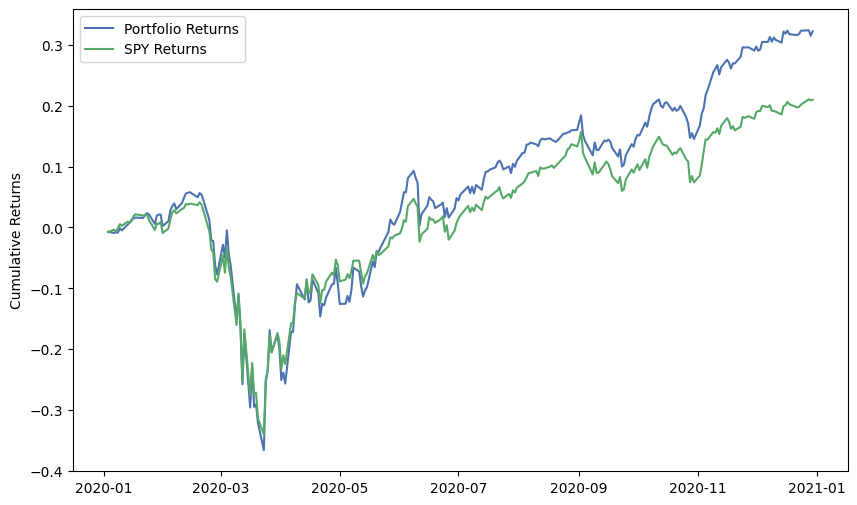

In [13]:
# Calculate portfolio and benchmark returns
portfolio_returns = portfolio_returns_1
benchmark_returns = spy_data.pct_change().dropna()

# Calculate portfolio and benchmark values
#portfolio_values = (1 + portfolio_returns).cumprod() * 10000
#benchmark_values = (1 + benchmark_returns).cumprod() * 10000

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
plt.legend()
#plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy.png', transparent=True)

# Backtesting - Out of Sample

In [14]:
#### Data Universe

print("Training Data start_date", start_date)

print("Training Data end_date", end_date)

next_day = end_date + timedelta(days=1)

# We invest on the next day using cleaned_weights

print("Testing Data start_date", next_day)

# Now we keep the target weights same for 1 year

next_year = end_date + relativedelta(years=1)

print("Testing Data end_date", next_year)

Training Data start_date 2020-01-01
Training Data end_date 2020-12-31
Testing Data start_date 2021-01-01
Testing Data end_date 2021-12-31


In [15]:
test_data = yf.download(tickers_list, start=next_day, end=next_year)['Adj Close']

[*********************100%***********************]  20 of 20 completed


In [16]:
testing_years = test_data.index.year.unique()
testing_months = test_data.index.month.unique()

print(testing_years, testing_months)

Index([2021], dtype='int32', name='Date') Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32', name='Date')


## Comparison with Benchmark Chart - Test Data 

In [17]:
# Create an empty Series to store portfolio returns
portfolio_test_returns = pd.Series()
portfolio_test_returns.index.name = 'Date'

# Extract unique years
unique_years = test_data.index.year.unique()

# Iterate through each year
for year in unique_years:
    
    # Filter the DataFrame for the current year
    current_year_prices = test_data[test_data.index.year == year]
    # to get the last day of the previous year prices
    previous_year_prices = test_data[test_data.index.year == year-1]
    # Concatenate the last day of the previous year with the current year's data
    # (to avoid NaN value for the first day of the year)
    current_year_prices = pd.concat([previous_year_prices.tail(1), current_year_prices])
    
    # Perform operations on the current_year_prices
    current_year_portfolio_returns = (current_year_prices.pct_change().dropna() * cleaned_weights).sum(axis=1)
    
    # Append current returns to the all_returns Series
    portfolio_test_returns = pd.concat([portfolio_test_returns, current_year_portfolio_returns])

In [18]:
#comparison with benchmark
spy_test_data = yf.download('SPY', start=next_day, end=next_year)['Adj Close']

[*********************100%***********************]  1 of 1 completed


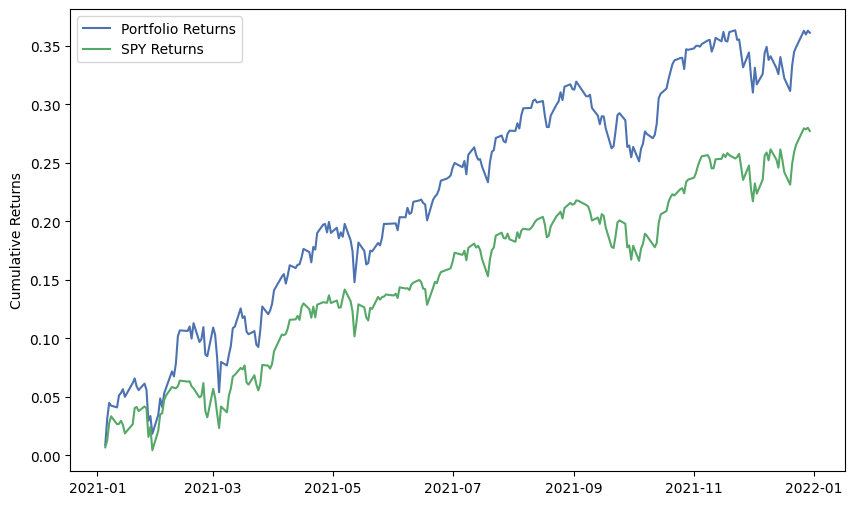

In [19]:
# Calculate portfolio and benchmark returns
portfolio_returns = portfolio_test_returns
benchmark_returns = spy_test_data.pct_change().dropna()

# Plot the returns
plt.figure(figsize=(10, 6), facecolor='none')
plt.plot(portfolio_returns.cumsum(), label='Portfolio Returns')
plt.plot(benchmark_returns.cumsum(), label='SPY Returns')
plt.legend()
#plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
#plt.title('Portfolio Returns vs SPY Returns')
# Remove background grid lines
plt.grid(visible=False)
plt.savefig('portfolio_vs_spy.png', transparent=True)

## Simulation Study

### 1. Markowitz with Monthly Rebalancing keeping Original Weights Only

In [20]:
# Calculate the discrete allocation of assets based on the optimal weights
latest_prices = test_data.iloc[0]  # Latest prices for the assets - as on 1 Jan 2021
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
old_allocation, leftover = da.lp_portfolio(verbose=True)

Funds remaining: 318.71
A: allocated 0.084, desired 0.080
AAPL: allocated 0.066, desired 0.068
ACGL: allocated 0.036, desired 0.034
ALB: allocated 0.046, desired 0.047
ALK: allocated 0.020, desired 0.021
ATO: allocated 0.082, desired 0.081
AXON: allocated 0.060, desired 0.053
BK: allocated 0.060, desired 0.059
C: allocated 0.017, desired 0.015
CINF: allocated 0.049, desired 0.045
COP: allocated 0.026, desired 0.026
DHI: allocated 0.054, desired 0.051
GNRC: allocated 0.046, desired 0.055
KLAC: allocated 0.026, desired 0.034
MCO: allocated 0.059, desired 0.048
MMC: allocated 0.079, desired 0.081
NCLH: allocated 0.000, desired 0.000
PNC: allocated 0.028, desired 0.033
PPG: allocated 0.070, desired 0.067
TYL: allocated 0.089, desired 0.101
Allocation has RMSE: 0.005


/home/bhavya/anaconda3/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Optimal Allocation: {'AAPL': 16, 'AMD': 22, 'BABA': 3, 'GOOG': 23, 'RRC': 177, 'WMT': 14}

In [21]:
print("Optimal Allocation:", old_allocation)
print("Leftover:", leftover)
print ("Actual Amount Allocated:", 10000-leftover)

Optimal Allocation: {'A': 7, 'AAPL': 5, 'ACGL': 10, 'ALB': 3, 'ALK': 4, 'ATO': 9, 'AXON': 5, 'BK': 15, 'C': 3, 'CINF': 6, 'COP': 7, 'DHI': 8, 'GNRC': 2, 'KLAC': 1, 'MCO': 2, 'MMC': 7, 'PNC': 2, 'PPG': 5, 'TYL': 2}
Leftover: 318.713835776216
Actual Amount Allocated: 9681.286164223784


### Now we calculate the portfolio value after one month and effective weights after one month - which is ratio of current assets vs Portfolio Value

In [22]:
#find first trading day of the next month

current_month_prices = test_data[(test_data.index.year == 2021) & (test_data.index.month == 12)]

current_month_prices = current_month_prices.sort_index()

#pandas series with stocks name as index, prices are values and date as index name
first_trading_day_prices = current_month_prices.iloc[-1]

In [23]:
#print(first_trading_day_prices)

In [24]:
print(old_allocation)

{'A': 7, 'AAPL': 5, 'ACGL': 10, 'ALB': 3, 'ALK': 4, 'ATO': 9, 'AXON': 5, 'BK': 15, 'C': 3, 'CINF': 6, 'COP': 7, 'DHI': 8, 'GNRC': 2, 'KLAC': 1, 'MCO': 2, 'MMC': 7, 'PNC': 2, 'PPG': 5, 'TYL': 2}


In [25]:
# Current Value of Each stock in allocated portfolio
result = first_trading_day_prices * pd.Series(old_allocation)

print(result)

A       1113.383881
AAPL     883.286362
ACGL     443.300018
ALB      695.956421
ALK      207.759995
ATO      905.948204
AXON     780.350037
BK       829.048004
C        170.710270
CINF     655.843597
COP      470.091881
DHI      845.921631
GNRC     705.919983
KLAC     418.814484
MCO      770.949585
MMC     1189.228180
NCLH            NaN
PNC      380.755859
PPG      831.913528
TYL     1076.239990
dtype: float64


In [26]:
new_portfolio_value = result.sum()

In [27]:
new_portfolio_value

13375.421909332275

In [28]:
print(spy_data)

10000/355.447

Date
2020-01-02    307.375610
2020-01-03    305.048187
2020-01-06    306.211853
2020-01-07    305.350922
2020-01-08    306.978241
                 ...    
2020-12-23    354.270966
2020-12-24    355.649139
2020-12-28    358.704437
2020-12-29    358.020172
2020-12-30    358.530975
Name: Adj Close, Length: 252, dtype: float64


28.13358953655538

In [29]:
current_effective_weights = result/new_portfolio_value

In [30]:
print(current_effective_weights)

A       0.083241
AAPL    0.066038
ACGL    0.033143
ALB     0.052032
ALK     0.015533
ATO     0.067732
AXON    0.058342
BK      0.061983
C       0.012763
CINF    0.049033
COP     0.035146
DHI     0.063244
GNRC    0.052777
KLAC    0.031312
MCO     0.057639
MMC     0.088911
NCLH         NaN
PNC     0.028467
PPG     0.062197
TYL     0.080464
dtype: float64


In [31]:
print(cleaned_weights)

OrderedDict([('A', 0.08031), ('AAPL', 0.06763), ('ACGL', 0.03398), ('ALB', 0.04677), ('ALK', 0.02097), ('ATO', 0.08083), ('AXON', 0.05295), ('BK', 0.05893), ('C', 0.01538), ('CINF', 0.04502), ('COP', 0.02604), ('DHI', 0.05109), ('GNRC', 0.05482), ('KLAC', 0.03442), ('MCO', 0.04839), ('MMC', 0.08106), ('NCLH', 0.0), ('PNC', 0.03345), ('PPG', 0.06736), ('TYL', 0.1006)])


In [32]:
ordered_dict = cleaned_weights
x1 = old_allocation

print(x1)

{'A': 7, 'AAPL': 5, 'ACGL': 10, 'ALB': 3, 'ALK': 4, 'ATO': 9, 'AXON': 5, 'BK': 15, 'C': 3, 'CINF': 6, 'COP': 7, 'DHI': 8, 'GNRC': 2, 'KLAC': 1, 'MCO': 2, 'MMC': 7, 'PNC': 2, 'PPG': 5, 'TYL': 2}


### working optimization problem - to allocate atleast the same amount of stocks allocated in the previous allocation (to only buy stocks and not sell)

In [33]:
min_value_constraints = {}
for key, value in x1.items():
    for index, (ordered_key, ordered_value) in enumerate(ordered_dict.items(), start=1):
        if key == ordered_key:
            new_key = int(index-1)
            min_value_constraints[new_key] = value
            break

In [34]:
min_value_constraints

{0: 7,
 1: 5,
 2: 10,
 3: 3,
 4: 4,
 5: 9,
 6: 5,
 7: 15,
 8: 3,
 9: 6,
 10: 7,
 11: 8,
 12: 2,
 13: 1,
 14: 2,
 15: 7,
 17: 2,
 18: 5,
 19: 2}

In [35]:
total_portfolio_value = 15000

#### Instantiate the CustomDiscreteAllocation class
da = CustomDiscreteAllocation(cleaned_weights, first_trading_day_prices, total_portfolio_value, min_value_constraints=min_value_constraints)

#### Call the lp_portfolio method with the additional constraint
new_allocation, leftover = da.lp_portfolio(reinvest=True, verbose=True)

#### Print the allocation and leftover value
print("Allocation:", new_allocation)
print("Leftover:", leftover)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-22
Funds remaining: 22.00
A: allocated 0.085, desired 0.080
AAPL: allocated 0.071, desired 0.068
ACGL: allocated 0.033, desired 0.034
ALB: allocated 0.046, desired 0.047
ALK: allocated 0.021, desired 0.021
ATO: allocated 0.081, desired 0.081
AXON: allocated 0.052, desired 0.053
BK: allocated 0.059, desired 0.059
C: allocated 0.015, desired 0.015
CINF: allocated 0.044, desired 0.045
COP: allocated 0.031, desired 0.026
DHI: allocated 0.056, desired 0.051
GNRC: allocated 0.047, desired 0.055
KLAC: allocated 0.028, desired 0.034
MCO: allocated 0.051, desired 0.048
MMC: allocated 0.079, desired 0.081
NCLH: allocated 0.000, desired 0.000
PNC: allocated 0.025, desired 0.033
PPG: allocated 0.067, desired 0.067
TYL: allocated 0.108, desired 0.101
Allocation has RMSE: 0.004
Allocation: {'A': 8, 'AAPL': 6, 'ACGL': 11, 'ALB': 3, 'ALK': 6, 'ATO': 12, 'AXON': 5, 'BK': 16, 'C': 4, 'CINF': 6, 'COP': 7, 'DHI': 8, 'G

### 2. Markowitz with Monthly Rebalancing - With Original Weights Revising every 12 months (Rolling Window)

TODO

# Beyond Markowitz - Hierarchical Risk Parity
HRP is a modern portfolio optimization method inspired by machine learning.

The idea is that by examining the hierarchical structure of the market, we can better diversify.

In [36]:
rets = expected_returns.returns_from_prices(historical_prices)

In [37]:
hrp = HRPOpt(rets)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('A', 0.06431),
             ('AAPL', 0.0707),
             ('ACGL', 0.03829),
             ('ALB', 0.0529),
             ('ALK', 0.02546),
             ('ATO', 0.08907),
             ('AXON', 0.04568),
             ('BK', 0.0463),
             ('C', 0.01279),
             ('CINF', 0.03182),
             ('COP', 0.02121),
             ('DHI', 0.03106),
             ('GNRC', 0.03946),
             ('KLAC', 0.04058),
             ('MCO', 0.03401),
             ('MMC', 0.12227),
             ('NCLH', 0.0098),
             ('PNC', 0.01748),
             ('PPG', 0.06632),
             ('TYL', 0.14051)])

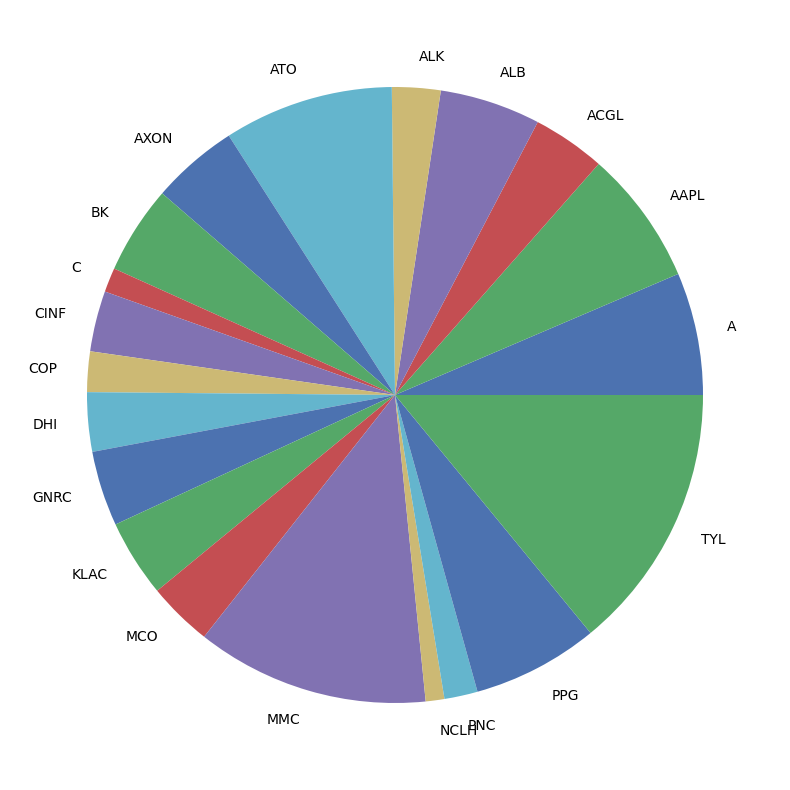

In [38]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [39]:
hrp.portfolio_performance(verbose=True);

Expected annual return: 31.5%
Annual volatility: 36.9%
Sharpe Ratio: 0.80


### Plotting

Plotting a dendrogram (tree diagram) based on the hierarchical structure of asset returns

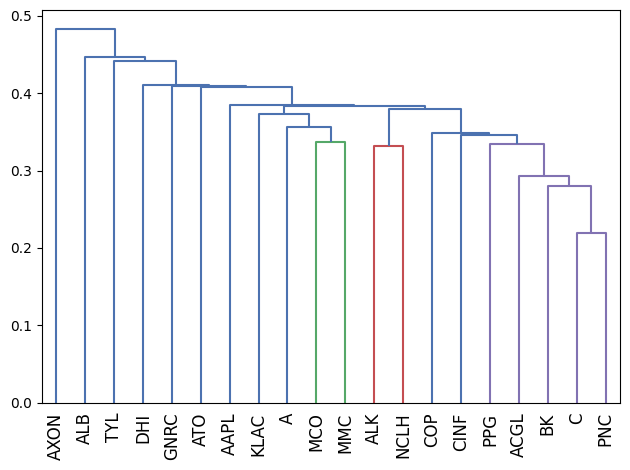

In [40]:
plotting.plot_dendrogram(hrp); 